Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Firstname Lastname | 01234567 | 30.03.2023, 08:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 2 &ndash; The Vanishing Gradient Problem (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter, A. Schörgenhumer<br>
<b>Date:</b> 21-03-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u2_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u2_utils.py</code> need to be installed.

<div class="alert alert-warning">
    <b>Important:</b> Set the random seed with <code>u2.set_seed(17)</code> to enable reproducible results in all tasks that incorporate randomness (e.g., t-SNE, splitting data intro train and test sets, initializing weights of a neural network, running the model optimization with random batches, etc.). You must use <code>17</code> as seed.
</div>

In [1]:
# Import pre-defined utilities specific to this notebook.
import u2_utils as u2

# Import additional utilities needed in this notebook.
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from typing import Dict, Sequence

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u2.setup_jupyter()

# Check minimum versions.
u2.check_module_versions()

Installed Python version: 3.10 (✓)
Installed numpy version: 1.24.3 (✓)
Installed pandas version: 1.5.3 (✓)
Installed PyTorch version: 1.13.1+cu116 (✓)
Installed scikit-learn version: 1.3.2 (✓)
Installed matplotlib version: 3.7.0 (✓)
Installed seaborn version: 0.12.2 (✓)


<h2>Definition of Auxiliaries</h2>

In this exercise, you will be working with a data set composed of images of various handwritten digits. It is probably <i>the</i> most prominent data set in the domain of machine learning: the <i>MNIST</i> data set. The data set distinguishes <i>ten</i> different classes, one for each digit (<i>zero</i> to <i>nine</i>). For curious minds, more information regarding this data set can be found at:

<center>
    <cite>LeCun, Y., 1998. The MNIST database of handwritten digits. <a href="http://yann.lecun.com/exdb/mnist/">http://yann.lecun.com/exdb/mnist/</a>.</cite>
</center><br>
    
Before analyzing and tackling the vanishing gradient problem, the data sets needs to be inspected.

<div class="alert alert-warning">
    <b>Exercise 1.1. [3 Points]</b>
    <ul>
        <li>Load the <i>MNIST</i> data set using the appropriate function as supplied by us.</li>
        <li>Split the data set into a training set and a test set in a ratio of $4:1$.</li>
        <li>Visualize the MNIST training set in tabular form.</li>
    </ul>
</div>

In [2]:
mnist_data = u2.load_mnist()
training_set, test_set = u2.split_data(mnist_data, test_size=1/5)
# data_wine_X, data_wine_y = data_wine.drop(columns='cultivator'), data_wine['cultivator']
print(f'  Full data set is of size: {mnist_data.shape[0]:>5}')
print(f'Training subset is of size: {training_set.shape[0]:>5}')
print(f' Testing subset is of size: {test_set.shape[0]:>5}')
mnist_data

  Full data set is of size: 70000
Training subset is of size: 56000
 Testing subset is of size: 14000


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,digit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


<div class="alert alert-warning">
    <b>Exercise 1.2. [3 Points]</b><br>
    Answer the following questions:
    <ul>
        <li>How many samples does the data set contain?</li>
        <li>How many samples does the training and the test set contain?</li>
        <li>How many features does the data set consist of (not counting the class label column <i>digit</i>)?</li>
    </ul>
</div>

There are 70000 and test contains 14000, training contains 56000 samples. Mnist contains 784 features 

<div class="alert alert-warning">
    <b>Exercise 1.3. [6 Points]</b>
    <ul>
        <li>Reduce the dimensionality of the MNIST training set using <i>t-SNE</i>. To avoid long computation times, select a subset of the training data with $n=3000$ samples, and then perform <i>PCA</i> with $40$ components first. Afterwards, apply t-SNE with $2$ components on this PCA data (choose the perplexity yourself).</li>
        <li>Visualize the t-SNE downprojection.</li>
    </ul>
</div>

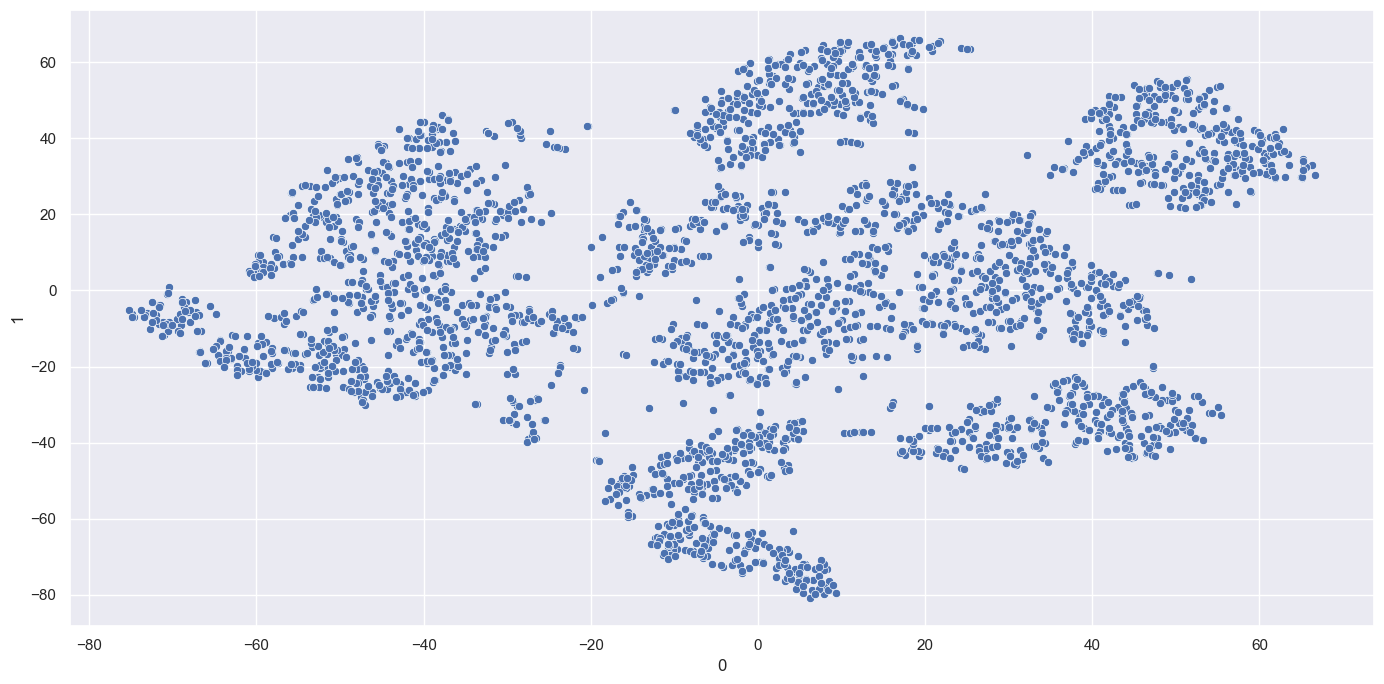

In [4]:
u2.set_seed(17)
# mnist_data_X, mnist_data_y = training_set.drop(columns='digit').loc[:1000], training_set['digit'].loc[:1000]
# mnist_data_pca = u2.apply_pca(n_components=40, data=mnist_data_X)
# u2.plot_points_2d(data=mnist_data_pca, targets=mnist_data_y, figsize=(14, 7))

mnist_data_pca = u2.apply_pca(training_set[:3000], n_components = 40)
mnist_data_tsne = u2.apply_tsne(n_components=2, data=mnist_data_pca, perplexity=25)
u2.plot_points_2d(data=mnist_data_tsne, figsize=(14, 7))

<div class="alert alert-warning">
    <b>Exercise 1.4. [2 Points]</b>
    <ul>
        <li>Comment on the separability of the MNIST training (sub)set with respect to the downprojection.</li>
    </ul>
</div>

After applying pca to tsne I can see there are 7 clusters with one cluster having the largest quantity of data points

<div class="alert alert-warning">
    <b>Exercise 1.5. [2 Points]</b>
    <ul>
        <li>Given the results above, do you think that there is some model that can classify the data set (decently) well? State your reasoning.</li>
    </ul>
</div>

Yes, there's a way. first we can split the data into the feature vector matrix and the label vector. Then apply pca with training data to reduce domintionality and apply k-means with 10 fixed clusters. 

<h2>Training of a Neural Network</h2>

Loading and inspecting a new data set is always an exciting moment, but even more exciting is the implementation of a corresponding neural network and applying it to said data set. In this section, you will thus have to implement and train an appropriate neural network model and revisit your knowledge about the <i>forward</i> as well as the <i>backward</i> pass.

<div class="alert alert-warning">
    <b>Important:</b> The following code snippet is taken from the accompanying exercise notebook. Do not modify this code here.
</div>

In [4]:
def train_and_evaluate(model: torch.nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int,
                       loader_train: torch.utils.data.DataLoader, loader_test: torch.utils.data.DataLoader,
                       device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> None:
    """
    Auxiliary function for training and evaluating a corresponding model.
    
    :param model: model instance to train and evaluate
    :param optimizer: optimizer to use for model training
    :param num_epochs: amount of epochs for model training
    :param loader_train: data loader supplying the training samples
    :param loader_test: data loader supplying the test samples
    :param device: device to use for model training and evaluation
    """
    model.to(device)
    
    for epoch in range(num_epochs):
        # Train model instance for one epoch.
        u2.train_network(
            model=model,
            data_loader=loader_train,
            device=device,
            optimizer=optimizer
        )

        # Evaluate current model instance.
        performance = u2.test_network(
            model=model,
            data_loader=loader_train,
            device=device
        )

        # Print result of current epoch to standard out.
        print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
              f'/ Train loss: {performance[0]:.4f} / Train accuracy: {performance[1]:.4f}')

    # Evaluate final model on test data set.
    performance = u2.test_network(model=model, data_loader=loader_test, device=device)
    print(f'\nTest loss: {performance[0]:.4f} / Test accuracy: {performance[1]:.4f}')

<div class="alert alert-warning">
    <b>Exercise 2.1. [4 Points]</b>
    <ul>
        <li>Create a corresponding <code>TensorDataset</code> for the training as well as the test set.</li>
        <li>Wrap the previously defined <code>TensorDataset</code> instances in separate <code>DataLoader</code> instances with a batch size of $80$ (shuffle the training data set).</li>
        <li>Scale the features of the training as well as test set by a factor of $\frac{1}{255}$, i.e., normalize the data to range $[0; 1]$</li>
    </ul>
</div>

In [42]:
u2.set_seed(17)
# #Scale the features of the training as well as test set by a factor of  1/255, i.e., normalize the data to range  [0;1]
mnist_train_scaled = training_set.astype(float) / 255
mnist_test_scaled = test_set.astype(float) / 255
#Create a corresponding TensorDataset for the training as well as the test set.
mnist_train_dataset, mnist_test_dataset=torch.utils.data.TensorDataset(
        torch.from_numpy(mnist_train_scaled.drop(columns='digit').values).reshape(-1, 1, 28, 28),
        torch.from_numpy(training_set['digit'].values)
    ), torch.utils.data.TensorDataset(
        torch.from_numpy(mnist_test_scaled.drop(columns='digit').values).reshape(-1, 1, 28, 28),
        torch.from_numpy(test_set['digit'].values)
    )
#Wrap the previously defined TensorDataset instances in separate DataLoader instances with a batch size of  80 (shuffle the training data set).    
loader_train_dataset = torch.utils.data.DataLoader(mnist_train_dataset,
                                                   batch_size = 80,
                                                   shuffle = True)
loader_test_dataset = torch.utils.data.DataLoader(mnist_test_dataset,
                                                  batch_size = 80,
                                                  shuffle = True)


<div class="alert alert-warning">
    <b>Exercise 2.2. [6 Points]</b>
    <ul>
        <li>Implement a class <code>FNN_0</code> with the following architecture (square weight matrix means that the input size is equal to the output size):</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>input size = $28\times{}28 = 784$</td>
        </tr>
        <tr>
            <td>1</td>
            <td>fully connected</td>
            <td>$512$ output features</td>
        </tr>
        <tr>
            <td>2</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>4</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>5</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>6</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>7</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>8</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>9</td>
            <td>fully connected</td>
            <td>square weight matrix</td>
        </tr>
        <tr>
            <td>10</td>
            <td>sigmoid</td>
            <td>-</td>
        </tr>
        <tr>
            <td>11</td>
            <td>fully connected</td>
            <td>$10$ output features</td>
        </tr>
    </table>
</div>

In [43]:
class FNN_0(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_2 = torch.nn.Linear(28 * 28, 512)
        self.sigmoid = torch.nn.Sigmoid()
        self.l3 = torch.nn.Linear(512, 512)
        self.l5 = torch.nn.Linear(512, 512)
        self.l7 = torch.nn.Linear(512, 512)
        self.l9 = torch.nn.Linear(512, 512)
        self.l11 = torch.nn.Linear(512, 10)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        x = self.l1_2(x)
        x = self.sigmoid(x)
        x = self.l3(x)
        x = self.sigmoid(x)
        x = self.l5(x)
        x = self.sigmoid(x)
        x = self.l7(x)
        x = self.sigmoid(x)
        x = self.l9(x)
        x = self.sigmoid(x)
        x = self.l11(x)
        return x

<div class="alert alert-warning">
    <b>Exercise 2.3. [3 Points]</b>
    <ul>
        <li>Create an instance of <code>FNN_0</code> as well as of a corresponding <code>SGD</code> optimizer with a learning rate of $0.05$.</li>
        <li>Print the resulting model and verify the architecture by inspecting the output.</li>
    </ul>
</div>

FNN_0(
  (l1_2): Linear(in_features=784, out_features=512, bias=True)
  (sigmoid): Sigmoid()
  (l3): Linear(in_features=512, out_features=512, bias=True)
  (l5): Linear(in_features=512, out_features=512, bias=True)
  (l7): Linear(in_features=512, out_features=512, bias=True)
  (l9): Linear(in_features=512, out_features=512, bias=True)
  (l11): Linear(in_features=512, out_features=10, bias=True)
)


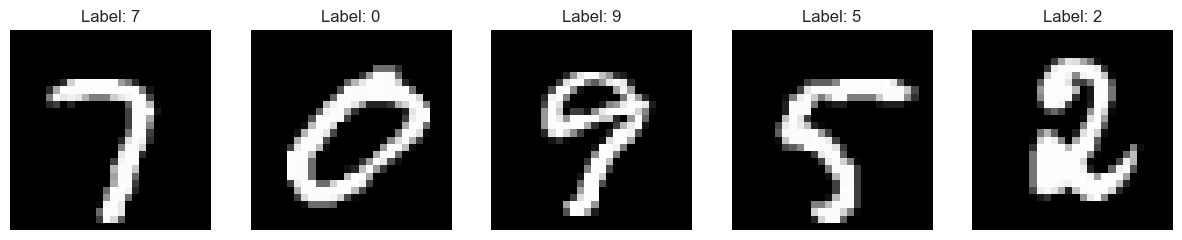

In [44]:
u2.set_seed(17)
fnn_0_model = FNN_0()
sgd_optimizer = torch.optim.SGD(fnn_0_model.parameters(), lr = 0.05)
print(fnn_0_model)

def visualize_samples(data_loader, num_samples=5):
    data_iter = iter(data_loader)
    images, labels = data_iter.__next__()
    images, labels = images.numpy(), labels.numpy()

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.set_title(f'Label: {labels[i]}')
        ax.axis('off')
    plt.show()

visualize_samples(loader_train_dataset)

<div class="alert alert-warning">
    <b>Exercise 2.4. [2 Points]</b>
    <ul>
        <li>Train an <code>FNN_0</code> network for $6$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy.</li>
    </ul>
</div>

In [45]:
u2.set_seed(17)
# Train and evaluate LogisticRegression instance on the Fashion-MNIST training set.
train_and_evaluate(
    model=fnn_0_model,
    optimizer=sgd_optimizer,
    num_epochs=6,
    loader_train=loader_train_dataset,
    loader_test=loader_test_dataset
)

Epoch: 1 / Train loss: 0.0290 / Train accuracy: 0.0974
Epoch: 2 / Train loss: 0.0289 / Train accuracy: 0.0988
Epoch: 3 / Train loss: 0.0290 / Train accuracy: 0.1121
Epoch: 4 / Train loss: 0.0288 / Train accuracy: 0.1121
Epoch: 5 / Train loss: 0.0289 / Train accuracy: 0.1049
Epoch: 6 / Train loss: 0.0289 / Train accuracy: 0.1021

Test loss: 0.0289 / Test accuracy: 0.1015


<div class="alert alert-warning">
    <b>Exercise 2.5. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

Since the data is reshaped and normalized, it appears that the training goes very slow. I think to improve the model we need to change architecture, learning rate, or optimizer.

<div class="alert alert-warning">
    <b>Exercise 2.6. [3 Points]</b>
    <ul>
        <li>Write down a formula for the corresponding <i>forward</i> pass of <code>FNN_0</code>. Use the same notation as presented during the exercise.</li>
    </ul>
</div>

p(y=k|\mathbf{x}_i) = \frac{e^{\text{NN}_k(\mathbf{x}_i;\mathbf{W})}}{\sum_{K} e^{\text{NN}_j(\mathbf{x}_i;\mathbf{W})}}

<div class="alert alert-warning">
    <b>Exercise 2.7. [4 Points]</b>
    <ul>
        <li>Write down a formula for the corresponding <i>backward</i> pass of <code>FNN_0</code>. Use the same notation as presented during the exercise.</li>
    </ul>
</div>

your answer goes here

<h2>Analyzing Gradients</h2>

Is the performance problem of <code>FNN_0</code> related to the vanishing gradient problem? This is exactly the point you're going to figure out in this exercise. As a first step, the gradients of a freshly initialized model need to be collected and analyzed. Afterwards, in case of a vanishing gradient problem, countermeasures must be taken.</p>

<div class="alert alert-warning">
    <b>Important:</b> The following code snippet is taken from the accompanying exercise notebook. Do not modify this code here.
</div>

In [ ]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader,
                      device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')) -> Sequence[Dict[str, np.array]]:
    """
    Auxiliary function for collecting gradients of a corresponding model.
    
    :param model: model instance to be used for collecting gradients
    :param loader: data loader supplying the samples used for collecting gradients
    :param device: device to use for gradient collection
    :return: sequence of parameter names and gradients, averaged over all parameter elements
    """
    model.to(device)
    model_state = model.training
    model.train()
    model.zero_grad()
    
    # Iterating over the data set and computing the corresponding gradients.
    # Since we are only interested in the gradients, we can skip the optimization step.
    gradients = {}
    criterion = torch.nn.CrossEntropyLoss()
    
    for data, target in loader:
        data, target = data.float().to(device), target.long().to(device)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
    
        # Collecting the (averaged absolute) gradients from the current model.
        for name, parameter in model.named_parameters():
            if "weight" in name and parameter.grad is not None:
                gradients.setdefault(name, []).append(parameter.grad.view(-1).abs().mean().item())
        model.zero_grad()
    
    # Reset model state and return collected gradients.
    model.train(mode=model_state)
    return gradients

<div class="alert alert-warning">
    <b>Exercise 3.1. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_0</code> and collect its gradients using the MNIST training set.</li>
    </ul>
</div>

<div class="alert alert-warning">
    <b>Exercise 3.2. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 3.3. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

your answer goes here

<div class="alert alert-warning">
    <b>Exercise 3.4. [6 Points]</b>
    <ul>
        <li>Assume a vanishing gradient. Apply the countermeasure presented during the accompanying exercise by implementing a corresponding <code>FNN_1</code> network.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 3.5. [3 Points]</b>
    <ul>
        <li>Create an instance of <code>FNN_1</code> as well as of a corresponding <code>SGD</code> optimizer with a learning rate of $0.05$.</li>
        <li>Print the resulting model and verify the architecture by inspecting the output.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 3.6. [3 Points]</b>
    <ul>
        <li>Train an <code>FNN_1</code> network for $6$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 3.7. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

your answer goes here

<div class="alert alert-warning">
    <b>Exercise 3.8. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_1</code> and collect its gradients using the MNIST training set.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 3.9. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly. Include the gradient visualization of <code>FNN_0</code> to enable a direct comparison.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 3.10. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

your answer goes here

<h2>Deriving Derivatives</h2>

It is already known from the lecture as well as the exercise that <i>activation</i> functions are the primary culprit of the <i>Vanishing Gradient Problem</i>. Hence, it is important to know <i>how</i> the chosen activation functions activate the input and consequently what the <i>derivative</i> is.

<div class="alert alert-warning">
    <b>Exercise 4.1. [4 Points]</b><br>
    Take a look at the official <a href="https://pytorch.org/docs/stable/generated/torch.nn.Hardsigmoid.html#torch.nn.Hardsigmoid">PyTorch documentation</a> to solve the following tasks:
    <ul>
        <li>Implement the <code>hardsigmoid</code> activation function as it was done for <code>relu</code> in the exercise.</li>
        <li>Implement the <i>derivative</i> of the <code>hardsigmoid</code> activation function accordingly.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 4.2. [3 Points]</b>
    <ul>
        <li>Find $5$ different inputs showing the <i>value range</i> of the <code>hardsigmoid</code> activation function as well as its derivative.</li>
        <li>Plot the <code>hardsigmoid</code> activation function including its derivative for the input range $[-8; 8]$.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 4.3. [4 Points]</b><br>
    Take a look at the official <a href="https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU">PyTorch documentation</a> to solve the following tasks:
    <ul>
        <li>Implement the <code>leaky_relu</code> activation function as it was done for <code>relu</code> in the exercise. Use a <i>negative slope</i> of $0.25$.</li>
        <li>Implement the <i>derivative</i> of the <code>leaky_relu</code> activation function accordingly.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 4.4. [3 Points]</b>
    <ul>
        <li>Find $5$ different inputs showing the <i>value range</i> of the <code>leaky_relu</code> activation function as well as its derivative.</li>
        <li>Plot the <code>leaky_relu</code> activation function including its derivative for the input range $[-8; 8]$.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 4.5. [2 Points]</b>
    <ul>
        <li>Which of these two activation functions from above do you think is susceptible to the vanishing gradient problem? Explain your decision.</li>
    </ul>
</div>

your answer goes here

<div class="alert alert-warning">
    <b>Exercise 4.6. [6 Points]</b>
    <ul>
        <li>Create the same network architecture as <code>FNN_0</code> but replace its activation function with the one you selected above in <b>Exercise 4.5.</b> (the one that is susceptible to the vanishing gradient problem). Name the new network <code>FNN_2</code>.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 4.7. [3 Points]</b>
    <ul>
        <li>Create a <i>fresh</i> instance of <code>FNN_2</code> and collect its gradients using the MNIST training set.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 4.8. [3 Points]</b>
    <ul>
        <li>Visualize the gradients of each weight parameter accordingly. Include the gradient visualization of <code>FNN_0</code> to enable a direct comparison.</li>
    </ul>
</div>

In [ ]:
# your code goes here

<div class="alert alert-warning">
    <b>Exercise 4.9. [2 Points]</b>
    <ul>
        <li>What do you observe?</li>
    </ul>
</div>

your answer goes here